# E-commerce Funnel Analysis & Conversion Rate Optimization

#### **Project Problem**
The e-commerce platform is currently achieving an overall sales conversion rate significantly below the industry benchmark. This indicates a **critical user experience issue** causing high abandonment and resulting in **substantial missed revenue opportunities**. The exact point of failure within the multi-stage customer journey is unknown.

#### **Project Goal**
The primary goal is to **diagnose the specific bottleneck stage** in the customer journey and use a segmented analysis (by brand/category) to provide **data-driven, actionable recommendations** that will measurably increase conversion rates at the identified drop-off point.

#### **Key Questions Addressed**
1. What is the overall **stage-to-stage conversion rate** for each step in the sales funnel?

2. Which specific stage represents the **single greatest source of user abandonment (the bottleneck)**?

3. Is the conversion issue systemic, or is the poor performance **localized to specific brands or product categories**?

4. What **actionable A/B test recommendations** can be made based on the top-performing segment data?

#### **Technical Stack**
|Tool|Purpose|
|----|-------|
|**PostgreSQL**|Used for efficient data ingestion and complex feature engineering (Window Functions and CTEs).|
|**Python**|Used for data preparation, final analysis, visualization (`seaborn`, `matplotlib`), and calculating rates.|

## 1. Importing Required Libraries, Loading Data and Basic Cleanup

In [1]:
import pandas as pd
import scipy as sp
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
event = pd.read_csv("D:/Downloads/events/events.csv")
event

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ
...,...,...,...,...,...,...,...,...,...
885124,2021-02-28 23:55:01 UTC,view,953226,2144415927553229037,NaN,NaN,219.94,1515915625611023730,FRLqIttxKU
885125,2021-02-28 23:58:05 UTC,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma
885126,2021-02-28 23:58:09 UTC,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd
885127,2021-02-28 23:58:14 UTC,view,888273,2144415921932861531,electronics.telephone,NaN,10.16,1515915625611024030,9pCbKMIcSx


In [3]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [4]:
# --- Drop null user_sessions ---
event.dropna(subset=['user_session'], inplace=True)
print(f"Rows remaining after dropping null sessions: {len(event)}")

Rows remaining after dropping null sessions: 884964


In [5]:
# --- Convert event_time into datetime object ---
event['event_time'] = pd.to_datetime(event['event_time'])

In [6]:
event.info()

<class 'pandas.core.frame.DataFrame'>
Index: 884964 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     884964 non-null  datetime64[ns, UTC]
 1   event_type     884964 non-null  object             
 2   product_id     884964 non-null  int64              
 3   category_id    884964 non-null  int64              
 4   category_code  648792 non-null  object             
 5   brand          672638 non-null  object             
 6   price          884964 non-null  float64            
 7   user_id        884964 non-null  int64              
 8   user_session   884964 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 67.5+ MB


## 2. Data Ingestion: Leveraging PostgreSQL for Feature Engineering
We are transferring the raw E-commerce events data from a Pandas DataFrame into a dedicated PostgreSQL database (`Funnel Analysis`).

#### **Rationale for using SQL over Pandas**
While Pandas is excellent for initial data cleaning and rapid exploration, we use PostgreSQL for the subsequent feature engineering steps because it offers significant advantages for this specific type of sequential analysis:

- **Scalability and Performance:** PostgreSQL is designed to handle and process large volumes of transactional data much more efficiently than an in-memory Pandas DataFrame, especially when dealing with complex joins and aggregations.

- **Demonstrating Advanced SQL:** The core of Funnel Analysis relies on **Window Functions** (`ROW_NUMBER()`, `LAG()`). These powerful, specialized functions are executed server-side in PostgreSQL, which is highly optimized for sequential and relational data logic, and demonstrates a critical data engineering skill.

- **Data Integrity:** Storing the processed data in a relational database ensures data persistence and facilitates better management and querying of the cleaned event log for future analysis.

This step establishes a robust, professional data pipeline where Python handles data movement, and SQL handles complex data transformation.

In [7]:
# 1. --- Define database connection details ---
db_user = "postgres"
db_pass = "123456789"
db_host = "localhost" 
db_port = "5433"

db_name = "Funnel Analysis" 

# 2. --- Create the database engine ---
# This uses the psycopg2 driver to connect to PostgreSQL database
db_url = f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}"
engine = create_engine(db_url)

# 3. --- Import data into SQL ---
table_name = "raw_user_events" 

print(f"Connecting to {db_name} and importing data...")

# The .to_sql() method executes the bulk insert (COPY) command efficiently
event.to_sql(
    table_name, 
    engine, 
    if_exists='replace', # Will create the table 'raw_user_events'
    index=False          
)

print(f"Data successfully imported into PostgreSQL table: {table_name}")

Connecting to Funnel Analysis and importing data...
Data successfully imported into PostgreSQL table: raw_user_events


## 3. SQL Feature Engineering (Building the Funnel Table)
Now that the data is in PostgreSQL, we'll run following two main SQL queries to convert the messy event history into a clean, actionable funnel table.

#### **A. Query 1: Cleaning and Event Ordering**
The goal is to filter for the relevant events (`view`, `cart`, `purchase`) and order them by session time.

```sql
CREATE TABLE Funnel_Events AS
SELECT
    user_id,
    user_session,
    event_time,
    event_type,
    -- Use ROW_NUMBER() to assign a sequential number to each event within a user session
    ROW_NUMBER() OVER (
        PARTITION BY user_session
        ORDER BY event_time
    ) AS event_sequence
FROM
    raw_user_events
WHERE
    event_type IN ('view', 'cart', 'purchase')
    AND user_id IS NOT NULL
ORDER BY
    user_session,
    event_time;
```
**Action:** This table (`Funnel_Events`) now contains only the actions that matter, numbered sequentially.

#### **B. Query 2: Calculating Conversion Counts**
Next, we count the unique users at each defined stage.

```sql
CREATE TABLE Funnel_User_Counts AS
SELECT
    'View Product' AS Stage,
    COUNT(DISTINCT user_id) AS Unique_Users
FROM Funnel_Events
WHERE event_type = 'view'

UNION ALL

SELECT
    'Add to Cart' AS Stage,
    COUNT(DISTINCT user_id) AS Unique_Users
FROM Funnel_Events
WHERE event_type = 'cart'

UNION ALL

SELECT
    'Purchase' AS Stage,
    COUNT(DISTINCT user_id) AS Unique_Users
FROM Funnel_Events
WHERE event_type = 'purchase';
```
**Action:** This table (`Funnel_User_Counts`) is the final SQL output needed to move back to Python for visualization.

## 4. Python Analysis and Visualization
The goal of this final step is to retrieve the calculated counts from PostgreSQL, determine the conversion rate, visualize the drop-offs, and generate actionable insights.

#### **A. Load the Final Data from PostgreSQL**
We will use Pandas to connect to our PostgreSQL database and execute a simple SELECT query to retrieve the final summary table (`funnel_user_counts`).

In [8]:
# --- 1. Database Connection Details  ---
user = "postgres"
password = "123456789"
host = "localhost" 
port = "5433"
name = "Funnel Analysis" # Database name with spaces

# Create the database engine
database_url = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{name}"
engine = create_engine(database_url)

# --- 2. Load the SQL-Engineered Table ---
funnel_table_name = "funnel_user_counts" 
df_funnel = pd.read_sql_query(f"SELECT * FROM \"{funnel_table_name}\" ORDER BY CASE stage WHEN 'View Product' THEN 1 WHEN 'Add to Cart' THEN 2 WHEN 'Purchase' THEN 3 END", engine)

# Convert to numeric and ensure order
df_funnel['unique_users'] = pd.to_numeric(df_funnel['unique_users'])

print("--- Funnel User Counts Loaded ---")
df_funnel

--- Funnel User Counts Loaded ---


,stage,unique_users
0,View Product,406817
1,Add to Cart,36948
2,Purchase,21304


#### **B. Calculate Stage-to-Stage Conversion Rates**
We will calculate the conversion rate between consecutive steps in the funnel using Pandas.

In [9]:
# Calculate the conversion rate from the previous stage
# We use .shift(1) to access the count from the preceding row
df_funnel['Users_at_Previous_Stage'] = df_funnel['unique_users'].shift(1).fillna(df_funnel['unique_users'].iloc[0])

# Calculate Conversion Rate (Current Users / Previous Users) * 100
df_funnel['Conversion_Rate_Pct'] = (df_funnel['unique_users'] / df_funnel['Users_at_Previous_Stage']) * 100

# The first stage (View Product) should always be 100% for the baseline
df_funnel.loc[0, 'Conversion_Rate_Pct'] = 100.0

print("\n--- Calculated Conversion Rates ---")
df_funnel


--- Calculated Conversion Rates ---


,stage,unique_users,Users_at_Previous_Stage,Conversion_Rate_Pct
0,View Product,406817,406817.0,100.000000
1,Add to Cart,36948,406817.0,9.082216
2,Purchase,21304,36948.0,57.659413


In [10]:
df_funnel['Conversion_Rate_Pct'] = round(df_funnel['Conversion_Rate_Pct'])

#### **C. Visualization and Interpretation**
Visualize the conversion rates to clearly identify the biggest drop-off point.

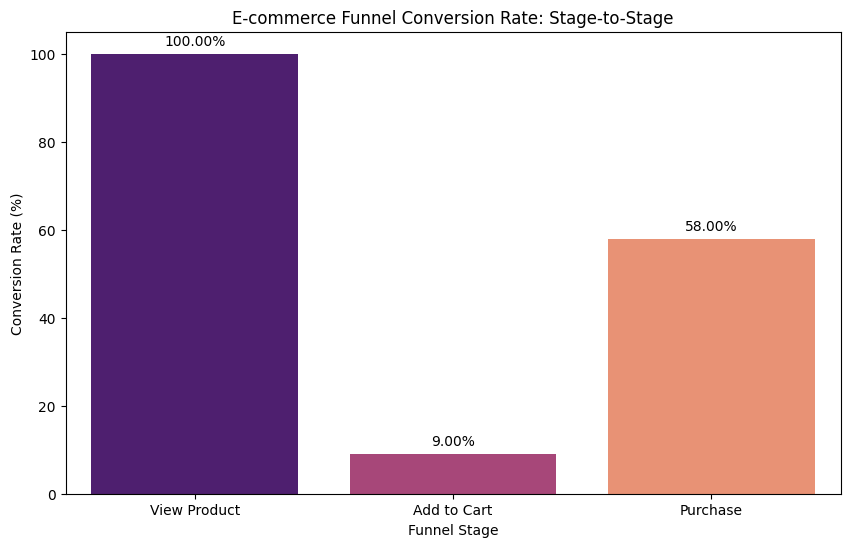

In [11]:
# Visualize the funnel conversion rates
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='stage', 
    y='Conversion_Rate_Pct', 
    data=df_funnel,
    hue='stage',
    palette='magma', # Use a distinct color palette
    legend=False
)
plt.title('E-commerce Funnel Conversion Rate: Stage-to-Stage')
plt.ylabel('Conversion Rate (%)')
plt.xlabel('Funnel Stage')
plt.ylim(0, 105)

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.show()

**Overall Conversion Rate**

In [12]:
# Get the unique user count for the start (View Product)
view_count = df_funnel.loc[df_funnel['stage'] == 'View Product', 'unique_users'].iloc[0]

# Get the unique user count for the end (Purchase)
purchase_count = df_funnel.loc[df_funnel['stage'] == 'Purchase', 'unique_users'].iloc[0]

# Calculate the overall conversion rate
overall_conversion_rate = (purchase_count / view_count) * 100

print(f"Total Unique Viewers: {view_count:,}")
print(f"Total Unique Purchasers: {purchase_count:,}")
print(f"\nOverall Funnel Conversion Rate (View Product to Purchase): {overall_conversion_rate:.2f}%")

Total Unique Viewers: 406,817
Total Unique Purchasers: 21,304

Overall Funnel Conversion Rate (View Product to Purchase): 5.24%


### Funnel Analysis: Identifying the Bottleneck

|Stage Transition|Conversion Rate|
|----------------|---------------|
|**View Product $\rightarrow$ Add to Cart**|9.00%|
|**Add to Cart $\rightarrow$ Purchase**|58.00% |
|**View Product $\rightarrow$ Purchase (Overall Coversion Rate)**|5.00%|

The most significant problem in our funnel is the transition from **Viewing a Product** to **Adding it to the Cart**.

#### 1. **The Critical Bottleneck**
The conversion rate from **View Product** to **Add to Cart** is only **9.00%**. This means that for every 100 users who look at a product page, **91 of them leave without showing explicit interest** (by adding to cart). This is an extremely low rate and represents the highest point of user loss.

#### 2. **High Conversion Later On**
The transition from **Add to Cart** to **Purchase** (which is calculated by `Purchase Count / Add to Cart Count`) is much healthier at **58.00%**. This indicates:

- Users who do successfully add an item to the cart are **highly motivated** to complete the purchase.

- The **checkout process** (payment, shipping calculation, account creation) **is relatively smooth** and is not the main source of user abandonment.


Our next step should be to use Our full dataset to perform a deeper analysis on the **91% of users who dropped off** after viewing the product. We could segment this group by `brand` to see if the issue is concentrated in specific product lines.

## 5. Deeper Dive Analysis - Segmenting the Bottleneck
The initial analysis revealed a critical bottleneck: the **View Product to Add to Cart (V $\rightarrow$ C) conversion rate is extremely low (9.00%)**.

This drop-off suggests a systemic problem on the product page, but we cannot apply a single fix to all products. Therefore, we must segment the low-performing stage to diagnose the specific point of failure.

#### **Hypothesis**
We hypothesize that the low V $\rightarrow$ C conversion is **not uniform** across all products, but is instead concentrated within specific **brands** or **product categories**.

#### **Action**
We will return to PostgreSQL to perform a new round of feature engineering, calculating the **V $\rightarrow$ C Conversion Rate segmented by the** `brand` **column**. This will allow us to identify:

1. **Worst Performers:** Brands where the problem is most severe (focus for immediate A/B testing).
2. **Best Performers:** Brands acting as a blueprint for best practices (lessons to be applied to the worst performers).

### 5.1. SQL Analysis: Brand Performance
The goal is to calculate the View Product $\rightarrow$  Add to Cart (VC) Conversion Rate for every brand in our raw_user_events table.
```sql
-- Create a new table to store the brand-level performance results
CREATE TABLE brand_vc_performance AS
WITH Brand_Views AS (
    -- CTE 1: Count unique users who viewed a product, segmented by brand
    SELECT
        brand,
        COUNT(DISTINCT user_id) AS total_viewers
    FROM raw_user_events
    WHERE event_type = 'view'
      AND brand IS NOT NULL
    GROUP BY 1
),
Brand_Carts AS (
    -- CTE 2: Count unique users who added to cart, segmented by brand
    SELECT
        brand,
        COUNT(DISTINCT user_id) AS total_cart_adders
    FROM raw_user_events
    WHERE event_type = 'cart'
      AND brand IS NOT NULL
    GROUP BY 1
)
SELECT
    v.brand,
    v.total_viewers,
    -- Use COALESCE to handle cases where a brand has views but zero carts
    COALESCE(c.total_cart_adders, 0) AS total_cart_adders,
    -- Calculate V->C conversion rate (Carts / Views) * 100
    (CAST(COALESCE(c.total_cart_adders, 0) AS NUMERIC) / v.total_viewers) * 100 AS vc_conversion_rate_pct
FROM
    Brand_Views v
LEFT JOIN
    Brand_Carts c ON v.brand = c.brand
WHERE
    v.total_viewers > 1000 -- -- Ensures we only analyze brands with a meaningful number of views
ORDER BY
    vc_conversion_rate_pct ASC;
```
**Action:** Once we run this query in pgAdmin, a new table named `brand_vc_performance` will be created.

### 5.2. Python Analysis: Visualization
Now, we switch back to Python to load the results, identify the best and worst performers, and visualize the findings.

#### **A. Load Data and Isolate Top/Bottom Performers**

In [13]:
# --- 1. Database Connection Details  ---
dbs_user = "postgres"
dbs_password = "123456789"
dbs_host = "localhost" 
dbs_port = "5433"
dbs_name = "Funnel Analysis" # Database name with spaces

# Create the database engine
dbs_url = f"postgresql+psycopg2://{dbs_user}:{dbs_password}@{dbs_host}:{dbs_port}/{dbs_name}"
dbs_engine = create_engine(dbs_url)

# --- 2. Load the SQL-Engineered Table ---
# Load the brand performance results from PostgreSQL
df_brand_perf = pd.read_sql_query(
    "SELECT * FROM brand_vc_performance", 
    dbs_engine
)
df_brand_perf

,brand,total_viewers,total_cart_adders,vc_conversion_rate_pct
0,hammer,1409,9,0.638751
1,lexmark,1492,22,1.474531
2,nokia,1525,33,2.163934
3,orient,1585,40,2.523659
4,honor,1207,33,2.734051
...,...,...,...,...
79,palit,9894,1808,18.273701
80,powercolor,1732,380,21.939954
81,gigabyte,9425,2353,24.965517
82,msi,7716,2202,28.538103


In [14]:
# Sort by conversion rate to find best and worst
df_brand_perf = df_brand_perf.sort_values(by='vc_conversion_rate_pct', ascending=False)

# Get the top 10 best-performing brands (highest conversion)
df_top_10 = df_brand_perf.head(10)

# Get the bottom 10 worst-performing brands (lowest conversion)
df_bottom_10 = df_brand_perf.tail(10)

In [15]:
print("--- Top 10 Best-Performing Brands (V->C Rate) ---")
df_top_10[['brand', 'vc_conversion_rate_pct']].reset_index(drop=True)

--- Top 10 Best-Performing Brands (V->C Rate) ---


,brand,vc_conversion_rate_pct
0,sapphire,29.537954
1,msi,28.538103
2,gigabyte,24.965517
3,powercolor,21.939954
4,palit,18.273701
5,nv-print,16.774194
6,amd,16.597353
7,asrock,15.840841
8,brother,15.663717
9,pantum,15.474553


In [16]:
print("\n--- Bottom 10 Worst-Performing Brands (V->C Rate) ---")
df_bottom_10[['brand', 'vc_conversion_rate_pct']].reset_index(drop=True)


--- Bottom 10 Worst-Performing Brands (V->C Rate) ---


,brand,vc_conversion_rate_pct
0,patriot,3.654485
1,redmond,3.592263
2,swat,3.549246
3,deepcool,3.200000
4,perfeo,2.926209
5,honor,2.734051
6,orient,2.523659
7,nokia,2.163934
8,lexmark,1.474531
9,hammer,0.638751


#### **B. Visualization: Comparative Plot**
The best way to present this finding is through a comparative plot that highlights the massive difference between the best and worst performers.**
We will create a visualization focusing on the worst-performing brands, as they offer the highest potential for immediate improvement.

In [17]:
# Overall average conversion rate %
avg_conversion_rate = round(df_brand_perf['vc_conversion_rate_pct'].mean())
avg_conversion_rate

9

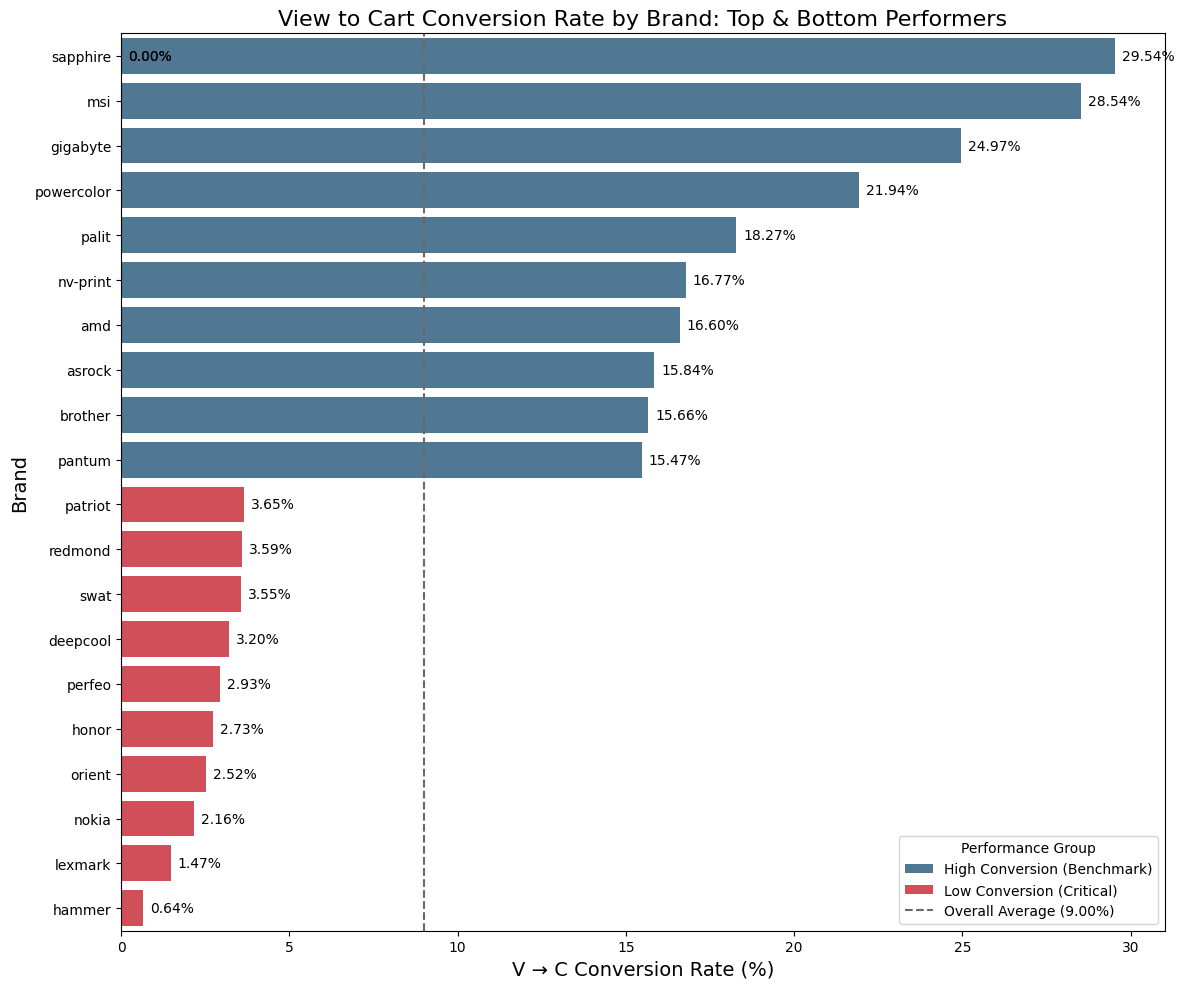

In [18]:
import numpy as np
# Combine data for plotting
df_plot = pd.concat([df_top_10, df_bottom_10])

# Define a metric to calculate if the brand is 'High' or 'Low' performance
# We'll use the overall average V->C rate (9.00%) as the benchmark
df_plot['performance_group'] = np.where(
    df_plot['vc_conversion_rate_pct'] > avg_conversion_rate,  
    'High Conversion (Benchmark)', 
    'Low Conversion (Critical)'
)

plt.figure(figsize=(12, 10))
ax = sns.barplot(
    data=df_plot,
    y='brand',
    x='vc_conversion_rate_pct',
    hue='performance_group', # Use the performance group for color separation
    palette={'Low Conversion (Critical)': '#e63946', 'High Conversion (Benchmark)': '#457b9d'},
    dodge=False 
)

plt.title('View to Cart Conversion Rate by Brand: Top & Bottom Performers', fontsize=16)
plt.xlabel('V → C Conversion Rate (%)', fontsize=14)
plt.ylabel('Brand', fontsize=14)

# Add a line for the overall average conversion rate (9.00%)
plt.axvline(9.00, color='dimgray', linestyle='--', label='Overall Average (9.00%)')
plt.legend(title='Performance Group')

# Add labels for precision
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(5, 0),
                textcoords='offset points')

plt.tight_layout()
plt.savefig('D:/top_bottom_performer.png')
plt.show()

### Interpretation: Localizing the Bottleneck
This section interprets the comparative bar chart (Top & Bottom Performers) against the overall average of 9.00%.A.

#### **Key Findings and Observations**
- **Massive Variance:** The chart clearly shows that the low overall V $\rightarrow$ C conversion is **not uniform**. There is a massive variance, ranging from excellent performance (e.g., **sapphire** at 29.54%) to near-zero performance (e.g., **hammer** at 0.64%).

- **The Blueprint:** The **Top 10 Brands** (blue bars) consistently achieve conversion rates far exceeding the overall average. This proves that high conversion is achievable on the platform.

- **The Problem Area:** The **Bottom 10 Brands** (red bars) are all significantly below the average, with rates barely above 0%. These product pages are failing to convince users and are the primary cause of the overall low V $\rightarrow$ C conversion.

- **Wasted Potential:** The worst performers (like **hammer**) are losing over **99%** of potential cart additions, indicating a critical issue such as poor media, lack of trust signals, or misleading product information.

## 6. Actionable Recommendations and Next Steps
This section translates the interpretation into specific, cost-effective business actions.

#### **A. Primary Recommendation:**
Focus & ReplicateThe project's primary recommendation is to treat the **Top Performers** as a **Blueprint for Best Practices** and prioritize all immediate optimization efforts on the **Bottom Performers**.

#### **B. Immediate Strategic Actions**
1. **High-Priority Audit (Bottom 3):** Launch an immediate qualitative audit of the product pages for the lowest-performing brands (e.g., **hammer**, **lexmark**, **nokia**). Specifically investigate:
    - Image quality and quantity.
    
    - Completeness of product descriptions.
  
    - Presence of key trust signals (reviews, guarantees).
  
2. **Blueprint Study (Top 3):** Conduct a deep dive into the product pages of **sapphire, msi, and gigabyte** to extract their common successful elements (e.g., media format, button placement, review prominence).

3. **A/B Test Implementation:** Create a new product page template incorporating the successful elements identified in the Blueprint Study. Launch an **A/B Test** comparing the **Current Low-Converting Page** (Control) against the **New Best-Practice Template** (Test) for the product lines of the Bottom 3 brands.


#### C. **Suggested Success Metric**
The A/B test will be considered successful if the new template achieves a **statistically significant** increase in the **View Product $\rightarrow$ Add to Cart (V $\rightarrow$ C) Conversion Rate**, ideally pushing the rate above the 9.00% overall benchmark.

## 7. Project Conclusion
This final section summarizes the technical achievements and the immediate business value delivered by the analysis.

#### **A. Technical Summary (SQL & Python Mastery)**
This project successfully developed an end-to-end data analysis pipeline, demonstrating proficiency across key tools:
- **Data Engineering (SQL/PostgreSQL):** Used advanced techniques, including **Window Functions** and **Common Table Expressions (CTEs)**, to transform raw, event-level data into structured, actionable funnel metrics.

- **Data Analysis (Python):** Employed `pandas` for rate calculation and `matplotlib/seaborn` for creating diagnostic visualizations, clearly isolating the critical bottleneck and subsequent localized failures.

#### **B. Business Value & Impact**
The analysis provided a quantifiable, evidence-based solution to a major revenue challenge:
- **Identified Bottleneck:** Pinpointed the **View Product $\rightarrow$ Add to Cart (V $\rightarrow$ C) transition** (overall 9.00% conversion) as the biggest area of user loss.

- **Localized the Cause:** Proved that the overall low performance is **not a site-wide systemic issue**, but a **localized content problem** by segmenting results by brand.

- **Provided Clear Path Forward:** Delivered specific recommendations to the e-commerce team, prioritizing the audit and redesign of product pages for the lowest-performing brands (e.g., **hammer** at 0.64%) by applying successful elements from the highest-performing brands (e.g., **sapphire** at 29.54%).

This project concludes with a clear, prioritized action plan designed to achieve a measurable increase in overall site conversion and revenue.